# Template Matching Tutorial Notebook  

## Autor: Verónica Gaete-Elgueta

This notebook walks through a full template-matching workflow for DAS seismic data, from building templates to comparing detections with an external catalog. It’s meant to be **hands-on**: you’ll load data, construct and visualize templates, run cross-correlation, and interpret the results.

---

## What you’ll do in this notebook

1. **Set up libraries & paths**  
   Import the required Python libraries and define directories for data, templates, and correlation results in a self-contained way.

2. **Build templates from DAS data**  
   Select events in time, extract short waveform windows around them, and save them as reusable templates.

3. **Visualize templates (raw & filtered)**  
   Plot template snippets in space and time, including band-pass filtered versions (e.g., 2–10 Hz), to understand their frequency content and spatial footprint.

4. **Run matching / cross-correlation**  
   Slide templates across a longer time window of DAS data, compute cross-correlations, and save the CC results for each template.

5. **Detect and cluster events**  
   Apply thresholds to the CC time series, group nearby peaks in time, and identify unique detected events.

6. **Compare with the IRIS catalog**  
   Overlay your detections with cataloged events to see which earthquakes are recovered, which might be missed, and where template matching finds additional signals.

---

By the end, you’ll have a complete example of how to go from **raw DAS files → templates → detections → catalog comparison** in a single, reproducible workflow.


![Data](./seismicitymap.png)


## Repo: https://dasway.ess.washington.edu/mora/index.html

## 0. Libraries


In [1]:
import os, re, glob
from datetime import datetime, timezone, timedelta
from typing import List
from scipy.signal import butter
import time
from pathlib import Path
from templatematching_cc import *
from getanalisisfiles import *
from template_maker_w import *

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


In [2]:
# -------- settings you likely only tweak here -------- 

# Where the DAS data live (this you still set explicitly)
#base_year_dir = '/data/data2/workshop/data/veronica'
base_year_dir ='home/jovyan/sz4d_das_workshop/data/veronica'
set_base_year_dir(base_year_dir)

# Folder where this notebook is running:
notebook_dir = Path.cwd()      # e.g. .../notebooks/veronica/template-matching

# Create local folders *next to the notebook*
templates_dir = notebook_dir / "templates"     # or "template" if you prefer
cc_base       = notebook_dir / "cc_results"

os.makedirs(templates_dir, exist_ok=True)
os.makedirs(cc_base, exist_ok=True)

print("Notebook dir: ", notebook_dir)
print("Templates dir:", templates_dir)
print("CC results dir:", cc_base)

# AUGUST window for templates (USGS events):
tmpl_start_dt = datetime(2023, 8, 27, 10, 0)
tmpl_end_dt   = datetime(2023, 8, 27, 10, 30)

# MATCHING window (example: full Oct 27 UTC)
match_start = "2023-08-27_09.00"
match_end   = "2023-08-27_11.00"

# DAS + filter
chan_min, chan_max = 1000, 1200
template_size = 5.0
fs = 50
samples_per_file = int(60 * fs)
b, a = butter(2, (2.0, 10.0), 'bp', fs=fs)

# filename pattern 
rx = re.compile(r"rainier_50Hz_(\d{4}-\d{2}-\d{2})_(\d{2})\.(\d{2})\.(\d{2})_UTC\.h5$")


Notebook dir:  /home/velgueta/notebooks/Workshop/template-matching
Templates dir: /home/velgueta/notebooks/Workshop/template-matching/templates
CC results dir: /home/velgueta/notebooks/Workshop/template-matching/cc_results


## 1. Template construction


In [3]:
# ---------------- A) TEMPLATES (AUGUST) ----------------
events = search(starttime=tmpl_start_dt,
                endtime=tmpl_end_dt,
                latitude=46.879967, longitude=-121.726906,
                maxradius=35/111.32)
event_df = get_summary_data_frame(events).sort_values("time")
print(f"[templates] usgs events in august: {len(event_df)}")

found_files = []
original_dates_fixed = []

miss = 0
hit  = 0
for _, row in event_df.iterrows():
    # event time as naive UTC datetime
    t_evt = row["time"]  # should already be UTC (pandas/obspy)
    if isinstance(t_evt, str):
        t_evt = datetime.strptime(
            t_evt.replace("_"," ").replace(".",":"),
            "%Y-%m-%d %H:%M:%S"
        ).replace(tzinfo=timezone.utc)
    else:
        t_evt = pd.Timestamp(t_evt).to_pydatetime().replace(tzinfo=timezone.utc)

    p = path_for_time(t_evt)
    if os.path.isfile(p):
        found_files.append(p)
        # template_maker2 expects 'YYYY-MM-DD HH:MM:SS.%f' for the event time
        original_dates_fixed.append(t_evt.strftime("%Y-%m-%d %H:%M:%S.%f"))
        hit += 1
    else:
       # print(f"No raw file for event: {t_evt.strftime('%Y-%m-%d_%H.%M.%S')}")
        miss += 1

if hit > 0:
    process_files_to_cut(
        found_files, original_dates_fixed,
        base_year_dir, templates_dir,
        chan_min, chan_max, template_size
    )
else:
    print("[templates] no templates cut (no august raw found)")

template_list = glob.glob(os.path.join(templates_dir, "*"))
#print(f"[templates] templates found on disk: {len(template_list)}")

[templates] usgs events in august: 2
Processing found file: /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.10.00_UTC.h5 with original date: 2023-08-27 10:10:23.740000
Loaded data shape: (3000, 201) for file /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.10.00_UTC.h5
Final cut data shape: (250, 201) for file /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.10.00_UTC.h5
Processing found file: /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.26.00_UTC.h5 with original date: 2023-08-27 10:26:15.030000
Loaded data shape: (3000, 201) for file /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.26.00_UTC.h5
Final cut data shape: (250, 201) for file /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.26.00_UTC.h5


In [4]:
print("BASE YEAR DIR:", base_year_dir)
t_evt0 = event_df["time"].iloc[0]
p0 = path_for_time(t_evt0)
print("Example path_for_time(t_evt0):", p0)
print("Exists? ->", os.path.isfile(p0))

BASE YEAR DIR: /data/data2/workshop/data/veronica
Example path_for_time(t_evt0): /data/data2/workshop/data/veronica/rainier_50Hz_2023-08-27_10.10.00_UTC.h5
Exists? -> True


## 2. Visualizing a Single Template (Raw vs. Bandpass-Filtered)

In this section we pick one template, plot the **raw DAS waveform** and its **2–10 Hz bandpass-filtered version** side by side. This helps you see how filtering enhances the coherent seismic signal and suppresses noise before running cross-correlation.



Plotting template file: /home/velgueta/notebooks/Workshop/template-matching/templates/2023-08-27_10-10-23.740000.h5


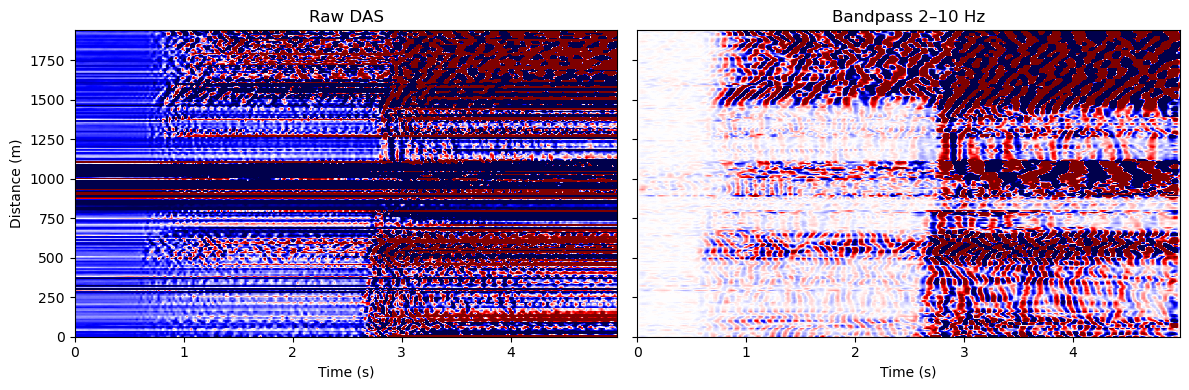

In [5]:
# 1. pick a template file from the templates folder
templates_dir = Path(templates_dir)   # already defined earlier
template_files = sorted(templates_dir.glob("*.h5"))

if not template_files:
    raise FileNotFoundError(f"No .h5 templates found in {templates_dir}")

file = template_files[0]   # change index if you want another one

print("Plotting template file:", file)

# 2. load the data explicitly from this template file
data = h5py.File(file, "r")
das  = np.array(data["Acquisition/Raw[0]/RawData"])
time = np.array(data["Acquisition/Raw[0]/RawDataTime"])
data.close()

# basic geometry / sampling
dt = 1 / 50.0    # 50 Hz
dx = 9.7
nt, nx = das.shape
x = np.linspace(0, (nx - 1) * dx, nx)
t = np.linspace(0, (nt - 1) * dt, nt)

# 3. bandpass filter 2–10 Hz
fs = 1.0 / dt
low, high = 2.0, 10.0
b, a = butter(2, [low / (fs / 2), high / (fs / 2)], btype="band")
das_filt = filtfilt(b, a, das, axis=0)

# 4. subplots: raw (left) and filtered (right)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

im0 = axes[0].imshow(
    das.T,
    aspect="auto",vmin=-1,vmax=1,
    extent=[t.min(), t.max(), x.min(), x.max()],
    cmap="seismic",
)
axes[0].set_title("Raw DAS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Distance (m)")

im1 = axes[1].imshow(
    das_filt.T,
    aspect="auto",vmin=-0.5,vmax=0.5,
    extent=[t.min(), t.max(), x.min(), x.max()],
    cmap="seismic",
)
axes[1].set_title("Bandpass 2–10 Hz")
axes[1].set_xlabel("Time (s)")

#fig.colorbar(im1, ax=axes.ravel().tolist(), label="raw phase (1/s)")
plt.tight_layout()
plt.show()


## 2. Matching / cross-correlation window (serial, no multiprocessing)


In [6]:
import time

file_list = build_file_list_julian(match_start, match_end)
#print(f"[matching] raw files: {len(file_list)} | templates: {len(template_list)}")

cc_out = os.path.join(cc_base, f"CC_{int(template_size)}sec-tem_{match_start}-{match_end}")
os.makedirs(cc_out, exist_ok=True)

if not file_list:
    print("[matching] no raw files in the chosen window")
elif not template_list:
    print("[matching] no templates available")
else:
    t0 = time.perf_counter()
    process_files_dos(
        file_list, template_list,
        chan_min, chan_max, (chan_max - chan_min),
        samples_per_file, b, a, cc_out
    )
    dt = time.perf_counter() - t0

Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
[matching] progress: 10/240 pairs (4.2%)Loaded template shape: (250, 200), raw_data shape: (3000, 20

Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
[matching] progress: 90/240 pairs (37.5%)Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 2

Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
[matching] progress: 180/240 pairs (75.0%)Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 200), timestamps shape: (3000,)
Loaded template shape: (250, 200), raw_data shape: (3000, 

## 3. Timestamps and plotting


In [7]:
# Build list of raw files in the matching window
file_list = build_file_list_julian(match_start, match_end)
print(f"[matching] raw files in window: {len(file_list)}")

# Subfolder for timestamps HDF5
ts_h5_dir = cc_base / "timestamps"
os.makedirs(ts_h5_dir, exist_ok=True)

if not file_list:
    print("[timestamps] no raw files; not creating timestamps HDF5")
    h5_path = None
else:
    # create_timestamps_h5 probably expects a string path
    h5_path = create_timestamps_h5(file_list, str(ts_h5_dir))
    print(f"[timestamps] written to: {h5_path}")

[matching] raw files in window: 120


Processing files: 100%|██████████| 120/120 [00:00<00:00, 599.97it/s]

Timestamps have been saved in the file /home/velgueta/notebooks/Workshop/template-matching/cc_results/timestamps/timestamps_50Hz_50Hz_2023-08-27.h5.
[timestamps] written to: /home/velgueta/notebooks/Workshop/template-matching/cc_results/timestamps/timestamps_50Hz_50Hz_2023-08-27.h5


In [8]:
# Make sure cc_base is a Path
cc_base = Path(cc_base)  # if it was a string before

# Time tag for this matching window
time_tag = f"{match_start}-{match_end}"  # e.g. "2023-08-27_09.00-2023-08-27_11.00"

# Base directory for CC results for this window
cc_window_dir = cc_base / f"CC_{int(template_size)}sec-tem_{time_tag}"

# --- choose which template's CC folder you want ---

# Option 1: just take the first template in the list
template_stem = Path(template_list[0]).stem   # e.g. "2023-08-27_10-10-23.740000"

# If you want a specific one, e.g. containing "10-10-23.740000", you could do:
# template_stem = next(
#     Path(t).stem for t in template_list
#     if "10-10-23.740000" in Path(t).stem
# )

# Full CC directory for that template
CC_DIR = cc_window_dir / template_stem

# HDF5 with timestamps created earlier
H5_FILE = Path(h5_path)

print("[CC_DIR ]", CC_DIR)
print("[H5_FILE]", H5_FILE)

t_abs, t_abs_aligned, cc, cc_files = load_cc_and_time(
    str(CC_DIR),
    str(H5_FILE),
    template_size_sec=template_size,
)

print(f"[align] N = {len(cc)}, range: {t_abs_aligned[0]} → {t_abs_aligned[-1]}")

[CC_DIR ] /home/velgueta/notebooks/Workshop/template-matching/cc_results/CC_5sec-tem_2023-08-27_09.00-2023-08-27_11.00/2023-08-27_10-10-23.740000
[H5_FILE] /home/velgueta/notebooks/Workshop/template-matching/cc_results/timestamps/timestamps_50Hz_50Hz_2023-08-27.h5
[CC] Loaded 120 files, total samples = 360000
[align] N = 360000, t_abs[0]=2023-08-27T09:00:00.003660, t_abs[-1]=2023-08-27T10:59:59.983660
[align] N = 360000, range: 2023-08-27T09:00:02.503660 → 2023-08-27T11:00:02.483660


N = 360000
time range: 2023-08-27 09:00:00.003660 → 2023-08-27 10:59:59.983660


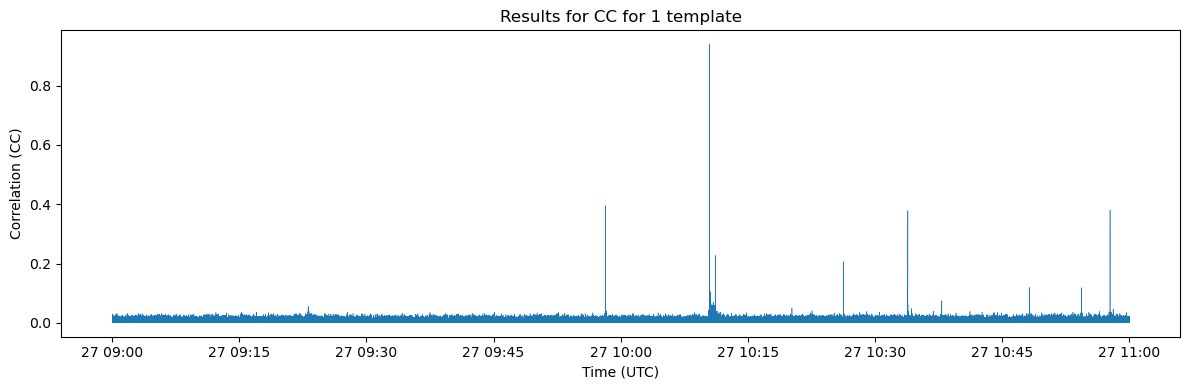

In [9]:
H5_FILE = Path(H5_FILE)  # ensure it's a Path object

# --- load timestamps from the HDF5 file ---
with h5py.File(H5_FILE, "r") as h5:
    ts_raw = h5["timestamps"][:]   # microseconds since epoch

# --- make sure CC and timestamps have the same length ---
N = min(len(cc), len(ts_raw))
cc_plot = np.asarray(cc[:N], float)
ts_raw = ts_raw[:N]

# --- convert to Python datetime for plotting ---
epoch = datetime(1970, 1, 1)
time_utc = np.array(
    [epoch + timedelta(microseconds=int(t)) for t in ts_raw]
)

print("N =", N)
print("time range:", time_utc[0], "→", time_utc[-1])

# --- simple plot: CC vs time ---
plt.figure(figsize=(12, 4))
plt.plot(time_utc, np.abs(cc_plot), lw=0.4)
plt.xlabel("Time (UTC)")
plt.ylabel("Correlation (CC)")
plt.title("Results for CC for 1 template")
plt.tight_layout()
plt.show()


In [10]:
Tecc_base = Path(cc_base)   # ensure Path
time_tag = f"{match_start}-{match_end}"  # same as before
cc_window_dir = cc_base / f"CC_{int(template_size)}sec-tem_{time_tag}"

# List all template subfolders inside this CC window
template_dirs = sorted(
    [p for p in cc_window_dir.iterdir() if p.is_dir()]
)

print("Found template CC folders:")
for i, d in enumerate(template_dirs):
    print(i, "→", d.name)
idx = 1   # change this to select another folder
CC_DIR = template_dirs[idx]
print("Using CC_DIR:", CC_DIR)


Found template CC folders:
0 → 2023-08-27_10-10-23.740000
1 → 2023-08-27_10-26-15.030000
Using CC_DIR: /home/velgueta/notebooks/Workshop/template-matching/cc_results/CC_5sec-tem_2023-08-27_09.00-2023-08-27_11.00/2023-08-27_10-26-15.030000


[CC] Loaded 120 files, total samples = 360000
[align] N = 360000, t_abs[0]=2023-08-27T09:00:00.003660, t_abs[-1]=2023-08-27T10:59:59.983660
N = 360000
time range: 2023-08-27 09:00:00.003660 → 2023-08-27 10:59:59.983660
Template folder: 2023-08-27_10-26-15.030000


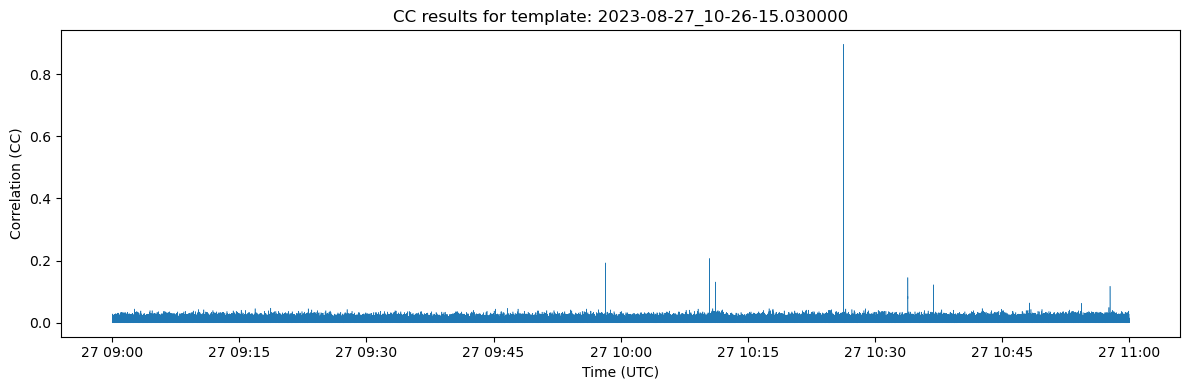

In [11]:
t_abs, t_abs_aligned, cc, cc_files = load_cc_and_time(
    str(CC_DIR),
    str(H5_FILE),
    template_size_sec=template_size,
)

# --- load timestamps from HDF5 ---
with h5py.File(H5_FILE, "r") as h5:
    ts_raw = h5["timestamps"][:]   # microseconds since epoch

# Ensure lengths match
N = min(len(cc), len(ts_raw))
cc_plot = np.asarray(cc[:N], float)
ts_raw = ts_raw[:N]

# Convert to datetime for plotting
epoch = datetime(1970, 1, 1)
time_utc = np.array(
    [epoch + timedelta(microseconds=int(t)) for t in ts_raw]
)

print("N =", N)
print("time range:", time_utc[0], "→", time_utc[-1])
print("Template folder:", CC_DIR.name)

# --- plot CC vs time ---
plt.figure(figsize=(12, 4))
plt.plot(time_utc, np.abs(cc_plot), lw=0.4)
plt.xlabel("Time (UTC)")
plt.ylabel("Correlation (CC)")
plt.title(f"CC results for template: {CC_DIR.name}")
plt.tight_layout()
plt.show()

## 4. Setting Up Thresholds and Time Tolerance

In this step we choose:

- a **correlation threshold** (`THRESH`) on |CC|  
- a **time tolerance** (`TOL_SEC`) used to merge nearby peaks into a single detected event  

These values are **not universal** – they will typically need to be adjusted for different datasets, stations, noise levels, and template quality. Think of them as tuning knobs: start with reasonable defaults, then refine them based on how many detections you see and how they compare to known events.


N = 360000 | time range: 2023-08-27 09:00:00.003660 → 2023-08-27 10:59:59.983660

Samples with |CC| >= 0.117: 32

Unique events (tolerance 6.0s): 7
  2023-08-27 09:58:13.423660  |CC| = 0.193
  2023-08-27 10:10:28.143660  |CC| = 0.207
  2023-08-27 10:11:09.923660  |CC| = 0.131
  2023-08-27 10:26:16.963660  |CC| = 0.896
  2023-08-27 10:33:52.963660  |CC| = 0.146
  2023-08-27 10:36:54.983660  |CC| = 0.122
  2023-08-27 10:57:44.803660  |CC| = 0.118


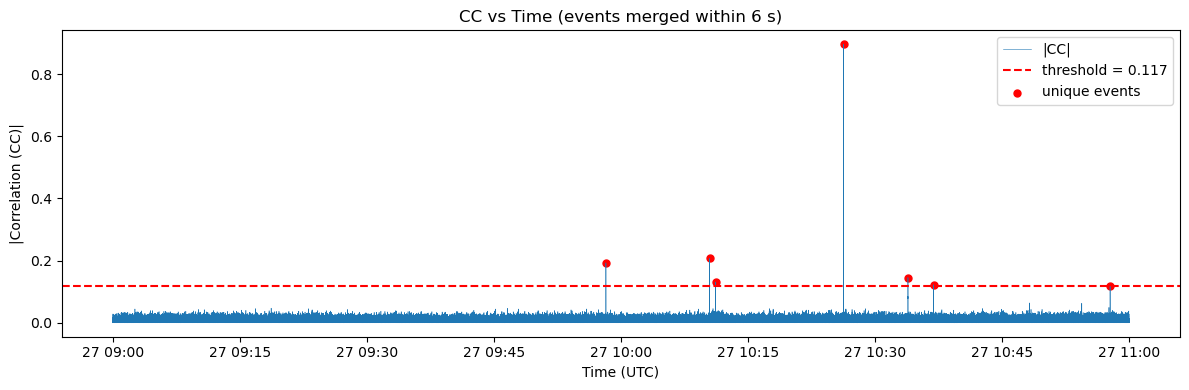

In [12]:
THRESH   = 0.117   # |CC| threshold
TOL_SEC  = 6.0     # merge hits within this time

# --- load timestamps and align with CC ---
with h5py.File(h5_path, "r") as h5:
    ts_raw = h5["timestamps"][:]  # microseconds since epoch

N       = min(len(cc), len(ts_raw))
cc_abs  = np.abs(np.asarray(cc[:N], float))
ts_raw  = ts_raw[:N]

epoch    = datetime(1970, 1, 1)
time_utc = np.array([epoch + timedelta(microseconds=int(t)) for t in ts_raw])

print("N =", N, "| time range:", time_utc[0], "→", time_utc[-1])

# --- hits over threshold ---
idx_hits = np.where(cc_abs >= THRESH)[0]
print(f"\nSamples with |CC| >= {THRESH}: {len(idx_hits)}")

event_times, event_vals = [], []
if idx_hits.size:
    hit_times = time_utc[idx_hits]
    hit_vals  = cc_abs[idx_hits]

    # cluster by time gaps > TOL_SEC
    clusters = []
    start = 0
    for i in range(1, len(hit_times)):
        if (hit_times[i] - hit_times[i-1]).total_seconds() > TOL_SEC:
            clusters.append((start, i))  # [start, i)
            start = i
    clusters.append((start, len(hit_times)))  # last cluster

    # pick max in each cluster
    for s, e in clusters:
        k = s + np.argmax(hit_vals[s:e])
        event_times.append(hit_times[k])
        event_vals.append(hit_vals[k])

    event_times = np.array(event_times)
    event_vals  = np.array(event_vals)

    print(f"\nUnique events (tolerance {TOL_SEC}s): {len(event_times)}")
    for t, v in zip(event_times, event_vals):
        print(f"  {t}  |CC| = {v:.3f}")
else:
    event_times = np.array([])
    event_vals  = np.array([])

# --- plot ---
plt.figure(figsize=(12, 4))
plt.plot(time_utc, cc_abs, lw=0.4, label="|CC|")
plt.axhline(THRESH, color="r", ls="--", label=f"threshold = {THRESH}")
if event_times.size:
    plt.scatter(event_times, event_vals, s=25, color="r", label="unique events")
plt.xlabel("Time (UTC)")
plt.ylabel("|Correlation (CC)|")
plt.title(f"CC vs Time (events merged within {TOL_SEC:.0f} s)")
plt.legend()
plt.tight_layout()
plt.show()

## 🏁 Last step: putting it all together


In [13]:
# ---- IRIS / ComCat query for the same time window ----
client = Client("IRIS")

start = UTCDateTime(time_utc[0])
end   = UTCDateTime(time_utc[-1])

LAT, LON = 46.879967, -121.726906
MAXR_KM = 35.0
MAXR_DEG = MAXR_KM / 111.32

cat = client.get_events(
    starttime=start,
    endtime=end,
    latitude=LAT,
    longitude=LON,
    maxradius=MAXR_DEG,
)

cat_times = np.array([ev.origins[0].time.datetime for ev in cat])
cat_mags  = np.array([ev.magnitudes[0].mag if ev.magnitudes else np.nan for ev in cat])

print(f"[IRIS] catalog events in window: {len(cat_times)}")
for t, m in zip(cat_times, cat_mags):
    if np.isnan(m):
        print(f"  {t}  M=?")
    else:
        print(f"  {t}  M={m:.2f}")

# ---- compare DAS events to catalog (time tolerance) ----
TOL_SEC = 10  # tolerance for matching catalog events, e.g. ±20 s
tol = np.timedelta64(int(TOL_SEC * 1000), "ms")

das64 = event_times.astype("datetime64[ms]")
cat64 = cat_times.astype("datetime64[ms]") if len(cat_times) else np.array([])

matched_idx = []
new_idx = []

for i, t in enumerate(das64):
    if cat64.size and np.any(np.abs(cat64 - t) <= tol):
        matched_idx.append(i)
    else:
        new_idx.append(i)

print(f"\nDAS unique events: {len(event_times)}")
print(f"  matched to catalog (±{TOL_SEC}s): {len(matched_idx)}")
print(f"  no catalog match: {len(new_idx)}")

for i in matched_idx:
    print(f"  MATCHED: {event_times[i]}  |CC|={event_vals[i]:.3f}")

for i in new_idx:
    print(f"  NEW:     {event_times[i]}  |CC|={event_vals[i]:.3f}")

[IRIS] catalog events in window: 6
  2023-08-27 10:57:37.070000  M=1.11
  2023-08-27 10:36:46.980000  M=0.38
  2023-08-27 10:33:48.930000  M=1.03
  2023-08-27 10:26:15.050000  M=0.59
  2023-08-27 10:10:23.770000  M=2.86
  2023-08-27 09:58:08.540000  M=0.95

DAS unique events: 7
  matched to catalog (±10s): 6
  no catalog match: 1
  MATCHED: 2023-08-27 09:58:13.423660  |CC|=0.193
  MATCHED: 2023-08-27 10:10:28.143660  |CC|=0.207
  MATCHED: 2023-08-27 10:26:16.963660  |CC|=0.896
  MATCHED: 2023-08-27 10:33:52.963660  |CC|=0.146
  MATCHED: 2023-08-27 10:36:54.983660  |CC|=0.122
  MATCHED: 2023-08-27 10:57:44.803660  |CC|=0.118
  NEW:     2023-08-27 10:11:09.923660  |CC|=0.131
